<a href="https://colab.research.google.com/github/Echoudexigaigu/test/blob/main/project_1_DLFL25U.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
---

In this programming assignment, we will train a neural net for caption generation.
This neural network is made of two components: a feed forward convolutional net (CNN) --- to extract features from the images --- and a recurrent neural net (RNN) --- to output a variable length caption for each input image.
We will use MNIST (handwritten digits) dataset for this purpose.

## Instructions
---

You should perform this assignment using Google Colab.
* Go through the notebook and ensure that you have answered all questions.
* Finally, submit the ipynb `File > Download > Download .ipynb` on Brightspace

---
This code snippet imports necessary libraries for working with numerical and
image data, defines the device for computation (either GPU or CPU), and sets up tools for building and training neural networks using PyTorch, a popular deep learning framework.

In [21]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import re

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

# Use this constant to decide on which device to run the training - On Colab 'cuda:0' and 'cpu' refers to GPU and CPU respectively
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set the random seed for reproducibility
seed = 31
torch.manual_seed(seed)
np.random.seed(seed)

## Data loading
---

This code snippet sets up data pre-processing and creates data loaders for training and testing using the MNIST data set, which is commonly used for hand-written digit classification tasks in machine learning.

`DataLoader`s abstract outs the loading of a data set and iterating batches of the loaded data set. You can read the documentation to learn more about `DataLoader`s and `Dataset`s [`DataLoader`s and `Dataset`s](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [22]:
# Batch options
batch_size = 128  # input batch size for training
test_batch = 1    # test batch size

# Normalizes the input images for a better training
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

# Get train and test loaders to load MNIST data
trainset = datasets.MNIST(root='.', train=True, download=True, transform=data_transform)
testset = datasets.MNIST(root='.', train=False, download=True, transform=data_transform)

# Create the dataloaders on which we can iterate to get the data in batch_size chunks
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=test_batch, shuffle=False, num_workers=0)

# 1 Preprocessing
## 1.1 Auxiliary data creation
---
First, let's setup `labels` and `vocab` for our problem statement. For this,
1. MNIST data set, consists of images and their corresponding labels of the form `{0, 1, 2, …}`.
First let's build a list mapping labels to `<b>` $\phi$ `<e>`, where $\phi \in \lbrace \texttt{zero}, \texttt{one}, \texttt{two}, \ldots , \texttt{nine}\rbrace$.

2. Build a lookup table for each unique tokens in the strings. Your `vocab` list, before sorting, should look like: `['<b>', 'z', 'e', 'r', 'o', '<e>', …]`.

Next, complete the following two functions:
1.   `label_to_onehot_sequence()` to convert a label to its one-hot sequence, representing the sequence of tokens. You may want to look at [`functional.one_hot` documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) for reference.
2. and `token_idx_to_token()` to convert the list of token indices to their corresponding string of characters.

The functions below are heavily annotated so that you understand what each function is doing and how can you use them for your use case.
The `assert` is a simple way for testing the correctness of your implementation.

In [23]:
digits = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
prefix, suffix = '<b>', '<e>'
# Create list and Lookup Table ###########################################
# TODO📝: labels = list of sequences of tokens such that it converts
#       label to digit into strings.
# TODO📝: vocab = list of all the unique tokens in labels.
################################################################################
#raise NotImplementedError("Please implement the code to create the labels and vocab")
labels = [prefix + d + suffix for d in digits]
print(labels)

tokens_unsorted = []
for lab in labels:
    toks = re.findall(r'<b>|<e>|[a-z]', lab)
    for t in toks:
        if t not in tokens_unsorted:
            tokens_unsorted.append(t)

vocab = sorted(tokens_unsorted)
print(vocab)

labelDict = {i: labels[i] for i in range(len(labels))}

vocab_size = len(vocab)
word_size = max([len(digit) for digit in digits]) + 2 # +2 for prefix and suffix

# Testing that your lookup tables are setup correctly
assert(vocab_size == 17)
assert(len(labelDict) == 10)

['<b>zero<e>', '<b>one<e>', '<b>two<e>', '<b>three<e>', '<b>four<e>', '<b>five<e>', '<b>six<e>', '<b>seven<e>', '<b>eight<e>', '<b>nine<e>']
['<b>', '<e>', 'e', 'f', 'g', 'h', 'i', 'n', 'o', 'r', 's', 't', 'u', 'v', 'w', 'x', 'z']


In [24]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
# Some utility functions to check if your code is working as intended
def assert_encoding(actual, expected):
  assert(type(actual) == type(torch.tensor(0))) # Your output is not of type tensor, please ensure that your function should output tensors
  if(not((expected.numpy() == actual.numpy()).all())):
    print('expected: ', expected)
    print('actual: ', actual)
    assert((expected.numpy() == actual.numpy()).all())

# Get the index of a token in the vocab
def get_idx(letter):
    return vocab.index(letter)
################################################################################

In [32]:
# Function to convert a list of labels to a list of one-hot matrix
def label_to_onehot_sequence(label):
    label_index = label.item() # Get the label
    tokens = re.findall(r'<b>|<e>|[a-z]', labels[label_index])
    # Map label -> one-hot sequence ############################################
    # TODO📝: complete the function converting a single label to its corresponsing one-hot
    # in: 9 out: one-hot('<b>nine<e>')
    ############################################################################
    #raise NotImplementedError("label_to_onehot_sequence() not implemented")
    idxs = [get_idx(tok) for tok in tokens]
    idxs = torch.tensor(idxs, dtype=torch.long)
    onehot = torch.nn.functional.one_hot(idxs, num_classes=vocab_size).to(torch.float32)
    return onehot



assert_encoding(label_to_onehot_sequence(torch.tensor(3)),
  torch.tensor([[
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   # <b>
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],   #  t
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  h
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],   #  r
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  e
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],   #  e
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], # <e>
    dtype=torch.float32))

In [33]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
def batch_of_labels_to_onehot_matrix(labels):
    # Convert labels to one-hot tensors
    onehot_inputs = [label_to_onehot_sequence(label) for label in labels]

    # Pad the length of string since, matrix operation requires fixed-size rows
    max_len = max(len(onehot) for onehot in onehot_inputs)
    padded_onehot = pad_sequence(onehot_inputs, batch_first=True, padding_value= 0)
    return max_len, padded_onehot

# Convert label to label onehot - used in the next to feed argmax input to RNN
def label_to_onehot(target):
    return F.one_hot(target, num_classes=10).to(torch.float32)
################################################################################

In [34]:
# To convert token indices predicted by our model back to characters and form the word
def token_idx_to_token(input):

    # Convert list of token idx to '<b>φ<e>' ##################################
    # TODO📝: complete the function to convert a list of token indices to the format '<b>φ<e>'
    # For each index in the input list, get the corresponding token from vocab, to build the output word
    # example input -> [ 0, 3, 6, 13, 2,  1] -> '<b>five<e>'
    #                    ⬇ ⬇ ⬇   ⬇ ⬇  ⬇
    #                   <b> f  i   v  e  <e>
    #raise NotImplementedError("token_idx_to_token() not implemented")
    output = ''
    for idx in input:
        output += vocab[idx]
    return output

assert(token_idx_to_token([0, 3,  6, 13,  2,  1]) == '<b>five<e>')

## 1.2 Data Exploration
---
1. Write code to fetch a batch from the `train_loader` and display the first 10 images along with their respective sequence of tokens which will be of the form `<b>` $\phi$ `<e>`, where $\phi \in \lbrace \texttt{zero}, \texttt{one}, \texttt{two}, \ldots, \texttt{nine}\rbrace$.

Use `matplotlib` and Jupyter notebook's visualisation capabilities. See this [PyTorch tutorial page](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for hints on how display images.

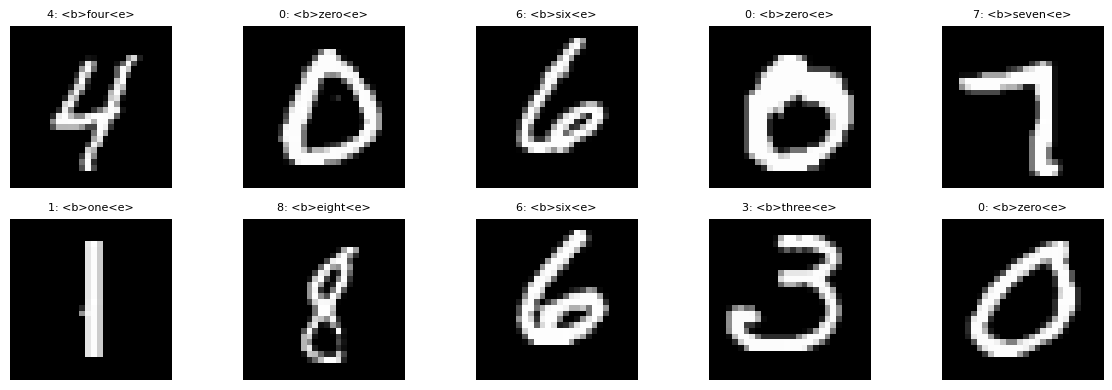

In [35]:
# Visualise the dataset images #################################################
# TODO📝: Fetch a batch from the train_loader and display the first 10 images along
#       with the label and the respective token sequence of the form <b>φ<e>
################################################################################
def visualise_images(train_loader, num_images=10):
    # Your code goes here
    # raise NotImplementedError("visualise_images() not implemented")
    images, targets = next(iter(train_loader))   # images: [B, 1, 28, 28], targets: [B]

    num_images = min(num_images, images.size(0))

    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        img = images[i].squeeze(0).numpy()
        label_idx = targets[i].item()
        token_seq = labels[label_idx]

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"{label_idx}: {token_seq}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Call the function to visualize the images along with the label
visualise_images(train_loader)  # Assuming `train_loader` is your DataLoader object

## Training and Validation Functions
---
⛔️⛔️⛔️ **Skip this cell for now, and you will have to revisit this cell 3 times, once you have defined your models in Section 2.1, 2.2, and 2.3.**

Below are the `train()` and `evaluate()` procedures that you will call using your model to train your model and get accuracy on the validation set respectively. A few lines are omitted in the functions. Complete the following parts:

1. Select the appropriate loss function for the tasks.
2. Perform the forward pass of the model.
3. Compute the loss.
4. Zero the gradients of the parameters for no gradient aggregation.
5. Compute gradients.
6. Optimization step.

Please go through both functions thoroughly to understand how accuracy is calculated and how input augmentation is performed before sending it to our models. This way, for other similar tasks, you can emulate similar functions in the future.

**`train()`** takes input parameters - **`num_epoch`, `optimiser`, `model`, `dataloader`, and `mode`**.

**`mode`** can have the following enums:

- `'ENCODER'` for training/evaluating CNN classifier - Section 2.1
- `'DECODER'` for training/evaluating the RNN model - Section 2.2
- `'MODULAR'` for evaluating the modular approach - Section 2.3
- `'E2E'` for training/evaluating the Sections 2.4 and 2.5

`evaluate()` takes input parameters - `model`, `dataloader`, and `mode`.

In [36]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
# Utility function to print statistics for debugging as well as modifies target and output for accuracy calculation
def trainUtility(batch_idx, epoch, output, target, padded_onehot):
    # Printing statistics for easy debugging
    if batch_idx == 1 or (epoch != None and epoch%500==0):
        _, pred_idx = torch.max(output, dim=-1)
        _, true_idx = torch.max(padded_onehot[:, 1:, :], dim=-1)
        print('acc: ', torch.sum(pred_idx == true_idx)/(pred_idx.shape[0]*pred_idx.shape[1]))
        print(pred_idx[0, :], true_idx[0, :])

    # Converting output of size (batch_size x max_word_length-1 x vocab_size) -> ((batch_size*(max_word_length-1)) x vocab_size)
    output =  output.view(-1, vocab_size)
    # Converting the true labels to ((batch_size*(max_word_length-1)) x vocab_size)
    # omitting the first character since, this is not getting predicted by the model
    target = padded_onehot[:, 1:, :].reshape(-1, vocab_size)

    return output, target
################################################################################

In [37]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
# We will create a custom dataset for training our RNN in part 2.2, data will be a tuple of
# one-hot matrix for each label (batch_size x 10) and corresponding one-hot matrix of words (batch_size x max_word_length x vocab_size)
class RnnTrainingDataset(Dataset):
    """Dataset to get a tuple of one-hot matrix for each label (batch_size x 10)
       and corresponding one-hot matrix of words (batch_size x max_word_length - 1 x vocab_size)"""

    def __init__(self):
        """
        Arguments:
        """
        self.X = label_to_onehot(torch.tensor([x for x in range(10)]))
        _, self.Y = batch_of_labels_to_onehot_matrix(torch.tensor([x for x in range(10)]))


    def __len__(self):
        return 10 # There are only 10 words

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

rnn_dataset = RnnTrainingDataset()
rnn_dataloader = torch.utils.data.DataLoader(rnn_dataset, batch_size=10, shuffle=True)
rnn_testloader = torch.utils.data.DataLoader(rnn_dataset, batch_size=1, shuffle=True)
################################################################################

In [95]:
# Function which does the training for number of epochs and model and type of model passed
def train(num_epochs, optimiser, model, dataloader=train_loader, mode='ENCODER'):
    model.to(device)
    model.train()
    crierion = None
    # Select Loss ##############################################################
    # TODO📝: criterion = loss function to classify into K classes
    ############################################################################
    if mode == 'ENCODER':
        criterion = nn.CrossEntropyLoss()
    elif mode == 'DECODER': # Changed to CrossEntropyLoss for sequence prediction
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    lr_list = []
    for epoch in range(num_epochs):
      for batch_idx, (data, target) in enumerate(dataloader):
          data = data.to(device)
          target = target.to(device)

          if(mode == 'E2E'): # For 2.4 and 2.5 - CNN-RNN models
            # Convert labels to one-hot tensors
            _, padded_onehot = batch_of_labels_to_onehot_matrix(target) # Output size (batch_size x max_word_length x vocab_size)
            padded_onehot = padded_onehot.to(device)

            output = None
            # Forward pass #####################################################
            # TODO📝: output = forward pass of your model
            ####################################################################
            raise NotImplementedError("Please implement the forward pass of your model")

            # Call trainUtility
            output, target = trainUtility(batch_idx, None, output, target, padded_onehot)


          elif(mode == 'ENCODER'): # For 2.1 - CNN classifier
            output = None
            # Forward pass #####################################################
            # TODO📝: output = forward pass of your model
            ####################################################################
            #raise NotImplementedError("Please implement the forward pass of your model")
            output = model(data)



          elif(mode == 'DECODER'): # For 2.2 - Overfitting RNN
            # Convert labels to one-hot tensors
            padded_onehot = target

            output = None
            # Forward pass #####################################################
            # TODO📝: output = forward pass of your model, you will not pass the
            #                  end token <e> to your model
            ####################################################################
            #raise NotImplementedError("Please implement the forward pass of your model")
            rnn_input_seq = padded_onehot[:, :-1, :]
            output = model(data, rnn_input_seq)
            # Call trainUtility
            output, target = trainUtility(batch_idx, epoch, output, target, padded_onehot)


          loss = None
          # Loss computation ###################################################
          # TODO📝: loss = evaluate the criterion on the model output
          ######################################################################
          if mode == 'ENCODER':
              loss = criterion(output, target)
          elif mode == 'DECODER':
              loss = criterion(output, target.float())
          else:
              raise NotImplementedError()

          # Zero grad ##########################################################
          # TODO📝: zero grad the parameters
          ######################################################################
          #raise NotImplementedError("Zero grad the parameters")
          optimiser.zero_grad()

          # Compute gradients ##################################################
          # TODO📝: back-propogate loss to calculate the grad weights
          ######################################################################
          #raise NotImplementedError("Back-propogate loss to calculate the grad weights")
          loss.backward()

          # Optimisation step ##################################################
          # TODO📝: perform a single optimization step (weight update)
          ######################################################################
          #raise NotImplementedError("Perform a single optimization step (weight update)")
          optimiser.step()

          if (batch_idx+1) % 100 == 0 or (mode == 'DECODER' and epoch%500 == 0):
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, batch_idx+1, len(dataloader), loss.item()))

In [64]:
################################################################################
###################### DO NOT MODIFY THIS CELL #################################
################################################################################
def evaluate(model, dataloader=test_loader, mode='ENCODER'):
    # Never forget to change model to eval mode using eval(), this freezes the model weights for updates
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:
        data = data.to(device)
        target = target.to(device)
        if(mode == 'ENCODER'):
          # Predicted output
          output = model(data)

          # Calculate correct prediction count
          pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        elif(mode == 'DECODER'):
          # Predicted output
          output = torch.tensor(model.sample(data), device=device)

          # True output
          _, true = torch.max(target, dim=-1)
          # Remove padding
          true = torch.tensor(np.concatenate(([0],np.delete(true.cpu().numpy(),
                                                            np.argwhere(true.cpu().numpy()==0)))), device=device)

          # Calculate correct prediction count
          print("Comparing output with true:", output.shape, true.shape)
          correct += torch.sum(output == true)/output.shape[0]
        elif(mode == 'MODULAR'):
          # Predicted output
          output = model.sample(data)

          # True output
          true = [labels[label.item()] for label in target]
          true_indices = [0] + [get_idx(c) for c in true[0][3:-3]] + [1]
          true = torch.tensor(true_indices)
          output = torch.tensor(output)
          true = torch.full(output.shape, 20) if output.shape[0] != true.shape[0] else true

          # Calculate correct prediction count
          correct += torch.sum(output == true)/output.shape[0]
        elif(mode == 'E2E'):
          # Predicted output
          output = torch.tensor(model.sample(data))

          # True output
          true = [labels[label.item()] for label in target]
          true_indices = [0] + [get_idx(c) for c in true[0][3:-3]] + [1]
          true = torch.tensor(true_indices)
          output = torch.tensor(output)
          true = torch.full(output.shape, 20) if output.shape[0] != true.shape[0] else true

          # Calculate correct prediction count
          correct += torch.sum(output == true)/output.shape[0]

    test_loss /= len(dataloader.dataset)
    print('\nTest set: Accuracy: {:.0f}/{} ({:.0f}%)\n'.format(
        correct, len(dataloader.dataset),
        100 * correct / len(dataloader.dataset)))

    return 100 * correct / len(dataloader.dataset)
################################################################################

# 2 Model creation and training
## 2.1 Convolutional net architecture
---
Follow the following steps to train a CNN classifier and calculate accuracy for your model on the test set:
1. Create a model exactly like the architecture given in the prog4 writeup.
2. Create a SGD optimiser. You can read about optimisers [here](https://pytorch.org/docs/stable/optim.html).
3. Go to previous section and fill out the `train()` procedure for `mode='ENCODER'`.

This part expects you to achieve an accuracy of `95%+` on the validation set.



In [65]:
# options
epochs = 10         # number of epochs to train
lr = 0.01           # learning rate

cnnEncoder = None
linearClassifier = None
# Convolutional net architecture ###############################################
# TODO📝: cnnEncoder = cnn model - input: image(batch_size x 1 x img_sz x img_sz)
#                                  output: (batch_size, 84)
# TODO📝: linearClassifier = linear classifier - input: (batch_size, 84)
#                                                output: (batch_size, 10)
################################################################################
#raise NotImplementedError("Please implement the CNN encoder and linear classifier")

class CnnEncoder(nn.Module):
    def __init__(self):
        super(CnnEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)   # 1x28x28 -> 6x26x26
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)      # 6x26x26 -> 6x13x13
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)  # 6x13x13 -> 16x11x11
        # 16x11x11 -> 16x5x5
        self.conv3 = nn.Conv2d(16, 120, kernel_size=3, stride=1) # 16x5x5 -> 120x3x3

        # Flatten: 120 * 3 * 3 = 1080
        self.fc1 = nn.Linear(120 * 3 * 3, 84)  # Linear-1: ? -> 84

    def forward(self, x):
        x = F.relu(self.conv1(x))      # (B,6,26,26)
        x = self.pool(x)               # (B,6,13,13)
        x = F.relu(self.conv2(x))      # (B,16,11,11)
        x = self.pool(x)               # (B,16,5,5)
        x = F.relu(self.conv3(x))      # (B,120,3,3)
        x = torch.flatten(x, 1)        # (B, 120*3*3 = 1080)
        x = F.relu(self.fc1(x))        # (B,84)
        return x
cnnEncoder = CnnEncoder()
linearClassifier = nn.Linear(84, 10)

cnnClassifier = nn.Sequential(cnnEncoder, linearClassifier)
enc_optimiser = None
# Creating Optimiser ###########################################################
# TODO📝: enc_optimiser = create a SGD optimiser for the cnnClassifier
# TODO📝: Fill out the train() procedure for mode='ENCODER' in the previous section
################################################################################
#raise NotImplementedError("Please implement the SGD optimiser")

enc_optimiser = optim.SGD(cnnClassifier.parameters(), lr=lr)


train(epochs, enc_optimiser, cnnClassifier, mode='ENCODER')
acc = evaluate(cnnClassifier, test_loader, mode='ENCODER')

assert(acc > 95)

Epoch [1/10], Step [100/469], Loss: 2.2868
Epoch [1/10], Step [200/469], Loss: 2.2061
Epoch [1/10], Step [300/469], Loss: 1.3019
Epoch [1/10], Step [400/469], Loss: 0.6691
Epoch [2/10], Step [100/469], Loss: 0.3664
Epoch [2/10], Step [200/469], Loss: 0.2341
Epoch [2/10], Step [300/469], Loss: 0.2799
Epoch [2/10], Step [400/469], Loss: 0.3125
Epoch [3/10], Step [100/469], Loss: 0.3296
Epoch [3/10], Step [200/469], Loss: 0.2981
Epoch [3/10], Step [300/469], Loss: 0.3006
Epoch [3/10], Step [400/469], Loss: 0.1756
Epoch [4/10], Step [100/469], Loss: 0.1849
Epoch [4/10], Step [200/469], Loss: 0.1873
Epoch [4/10], Step [300/469], Loss: 0.1162
Epoch [4/10], Step [400/469], Loss: 0.0911
Epoch [5/10], Step [100/469], Loss: 0.1242
Epoch [5/10], Step [200/469], Loss: 0.0775
Epoch [5/10], Step [300/469], Loss: 0.0732
Epoch [5/10], Step [400/469], Loss: 0.0680
Epoch [6/10], Step [100/469], Loss: 0.0963
Epoch [6/10], Step [200/469], Loss: 0.1072
Epoch [6/10], Step [300/469], Loss: 0.1368
Epoch [6/10

## 2.2 Recurrent net overfitting
---
We can define models in two ways, either using `nn.Sequential()` to create a network where PyTorch takes care of `forward()`, or we can create a `class` inhereted from `nn.Module` and define our custom `forward()` and other utility functions. For this section, we will use the latter approach.
Follow the next steps to train your RNN model and calculate the accuracy:
1. Create a model by completing the class methods where asked.
2. Create an optimiser.
3. Go to previous section and fill out the `train()` procedure for `mode='DECODER'`.

This part expects you to achieve an accuracy of `10/10` on the training set, that is we completely memorise the training data points.


You can use the following documentations for reference on [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) and [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).


In [101]:
# 1. RNN model for learning sequence of letters
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        # Create LSTM and Linear objects #######################################
        # TODO📝: self.lstm = LSTM object using input_size, hidden_size and num_layers,
        #                     set the batch_first option to True
        # TODO📝: self.fc = Linear layer to convert to get final output with size
        #                   (batch_size x vocab_size)
        ########################################################################
        #raise NotImplementedError("Please implement the LSTM and Linear layers")
        self.lstm = nn.LSTM(
          input_size=vocab_size + input_size,
          hidden_size=hidden_size,
          num_layers=num_layers,
          batch_first=True
        )
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, input, target):
        # input is batch of one-hot labels of shape (batch_size x 10)
        # target is one-hot of sequence of tokens without the last token and is of
        # shape (batch_size x max_word_length-1 x vocab_size)

        max_word_length = None

        # Setup ################################################################
        # TODO📝: Using target assign the three variables with the corresponding values of
        #         batch_size, max_word_length, and vocab_size
        ########################################################################
        #raise NotImplementedError("Please implement the setup of _, max_word_length and _")
        batch_size, max_word_length, vocab_size = target.shape

        max_word_length += 1
        replicated_input = None
        rnn_input = None

        # Feed-forward behaviour of the model ##################################
        # In order to pass two inputs to our LSTM object, we need to concat input and target,
        # we will need to change (batch_size x 10) input matrix -> (batch_size x max_word_length-1 x 10)
        # TODO📝: replicated_input = repeat the one-hot input (max_word_length-1)
        #         times on 2nd dimension -> (batch_size x max_word_length-1 x 10)
        # TODO📝: rnn_input = concat the target with the replicated_input ->
        #         (batch_size x max_word_length-1 x vocab_size+10)
        #raise NotImplementedError("Feed-forward behaviour of the model")
        replicated_input = input.unsqueeze(1).repeat(1, max_word_length - 1, 1)
        rnn_input = torch.cat((target, replicated_input), dim=2)

        out = None
        # TODO📝: out = write the feed-forward behaviour of the network
        ########################################################################
        #raise NotImplementedError("Please implement the feed-forward behaviour of the network")
        out, _ = self.lstm(rnn_input)
        out = self.fc(out)

        return out

    # Utility function to create next input_rnn using the current token and one-hot label(input)
    def create_concatenated_rnn_input(self, token_idx, input_digit):
        # input is single one-hot label of shape (1 x 10)
        # token_idx is a token index
        rnn_input = None
        # Create rnn_input of (1 x 1 x vocab_size+10) ##########################
        # TODO📝: rnn_input = matrix of (1 x 1 x vocab_size+10), which is the concatenation
        #         of the input and the one-hot vector corresponding to the token idx
        ########################################################################
        #raise NotImplementedError("Please implement the rnn_input creation")


        # input_digit: (1, 10)
        # token_idx: scalar int
        # (1,) -> one-hot (1, vocab_size)
        if isinstance(token_idx, torch.Tensor):
            token_idx = token_idx.item()
        token_onehot = F.one_hot(
            torch.tensor([token_idx], device=input_digit.device),
            num_classes=vocab_size
        ).to(torch.float32)
        input_digit = input_digit.unsqueeze(1)     # (1,1,10)
        token_onehot = token_onehot.unsqueeze(1)   # (1,1,vocab_size)

        rnn_input = torch.cat([input_digit, token_onehot], dim=2)
        return rnn_input

    # This function samples next token given the <b> token until the <e> token
    def sample(self, input):
        # input is single one-hot label of shape (1 x 10)
        output = [get_idx('<b>')] # Output is sequence of token indices, and here we intialise with <b>
        rnn_input = self.create_concatenated_rnn_input(get_idx('<b>'), input) # create first input
        loopRun = 0
        hidden = None

        while True and loopRun < 50:  # Breaking condition : predicted idx == <e>
            # the loopRun < 50 condition prevent infinite looping
            out = None
            # Feed-forward behaviour ###########################################
            # TODO📝: out = write the feed-forward behaviour
            # Here, since we are working with single token at a time,
            # you need to convert out: (1 x 1 x vocab_size) -> (1 x vocab_size)
            ####################################################################
            #raise NotImplementedError("Please implement the feed-forward behaviour of the network")
            out, hidden = self.lstm(rnn_input, hidden)   # out: (1,1,hidden)
            out = self.fc(out)                           # (1,1,vocab_size)
            out = out.squeeze(1)
            _, pred_idx = torch.max(out, dim=-1)

            idx = pred_idx.item()
            output.append(idx)
            # Breaking condition ###############################################
            # TODO📝: add breaking condition on predicted token == '<e>'
            ####################################################################
            if(pred_idx == get_idx('<e>')):
                break

            # Prepare next rnn input ###########################################
            # TODO📝: rnn_input = overwrite the rnn_input using the current
            #         predicted token for the next iteration
            ####################################################################
            #raise NotImplementedError("Please implement the rnn_input creation")
            rnn_input = self.create_concatenated_rnn_input(pred_idx, input)

            loopRun+=1

        return output

In [104]:
# 2. Create an optimiser
# options
epochs = 5000         # number of epochs to train
lr = 0.5           # learning rate - TODO📝: set an appropriate lr
hidden_size = 16    # hidden size for rnn - TODO📝: set from 8, 16, 32, 64 - use the smallest one for which your model works
embed_size = 10       # input is onehot labels
num_layer = 1         # layers of rnn

rnnModel = None
dec_optimiser = None
# Recurrent net overfitting ####################################################
# TODO📝: rnnModel = DecoderRNN() model - input: one-hot label output: one-hot matrix of words
# TODO📝: dec_optimiser = create a SGD optimiser object
################################################################################
#raise NotImplementedError("Please implement the DecoderRNN and SGD optimiser")
rnnModel = DecoderRNN(input_size=embed_size,
                      hidden_size=hidden_size,
                      vocab_size=vocab_size,
                      num_layers=num_layer).to(device)

dec_optimiser = optim.SGD(rnnModel.parameters(), lr=lr)

train(epochs, dec_optimiser, rnnModel, mode='DECODER', dataloader=rnn_dataloader)
acc = evaluate(rnnModel, rnn_testloader, mode='DECODER')

assert(acc == 100)

acc:  tensor(0.0500, device='cuda:0')
tensor([10, 10, 10,  3, 10, 10], device='cuda:0') tensor([16,  2,  9,  8,  1,  0], device='cuda:0')
Epoch [1/5000], Step [1/1], Loss: 0.6867
acc:  tensor(0.1667, device='cuda:0')
tensor([1, 1, 1, 1, 1, 1], device='cuda:0') tensor([7, 6, 7, 2, 1, 0], device='cuda:0')
Epoch [501/5000], Step [1/1], Loss: 0.1738
acc:  tensor(0.2167, device='cuda:0')
tensor([2, 1, 1, 1, 1, 1], device='cuda:0') tensor([8, 7, 2, 1, 0, 0], device='cuda:0')
Epoch [1001/5000], Step [1/1], Loss: 0.1691
acc:  tensor(0.2500, device='cuda:0')
tensor([2, 2, 2, 1, 1, 1], device='cuda:0') tensor([11, 14,  8,  1,  0,  0], device='cuda:0')
Epoch [1501/5000], Step [1/1], Loss: 0.1635
acc:  tensor(0.3167, device='cuda:0')
tensor([2, 2, 2, 2, 2, 1], device='cuda:0') tensor([11,  5,  9,  2,  2,  1], device='cuda:0')
Epoch [2001/5000], Step [1/1], Loss: 0.1554
acc:  tensor(0.3667, device='cuda:0')
tensor([2, 6, 2, 2, 1, 1], device='cuda:0') tensor([ 3,  6, 13,  2,  1,  0], device='cuda:0'

RuntimeError: The size of tensor a (4) must match the size of tensor b (5) at non-singleton dimension 0

## 2.3 Modular approach
---
In this section, we will combine the previously trained CNN and RNN to convert an input image to a sequence of tokens.
Here, since both models are pre-trained we just evaluate the performance of this combined model.

Create a class `CombinationModel`: with a `sample()` method which takes an image as input and outputs token indices for each predicted letter of size `(batch_size x word_length)`. You can call the sample method of `DecoderRNN` for this purpose.

In [ ]:
# Modular approach #############################################################
# TODO📝: create a class as mentioned before
# TODO📝: combinationModel = instantiate your created class
################################################################################

class CombinationModel(nn.Module):
    def __init__(self, cnn, rnn): # Everything here is pretrained
        super(CombinationModel, self).__init__()
        self.cnn = cnn
        self.rnn = rnn

    def sample(self, image):
        raise NotImplementedError("Please implement the sample method")

combinationModel = CombinationModel(cnnClassifier, rnnModel)

acc = evaluate(combinationModel, test_loader, mode='MODULAR')

assert(acc > 95)

## 2.4 Transfer learning
---

In this section, we will use the `cnnEncoder` that we trained in section 2.1 to get the image embeddings which we will use instead of the one-hot label we used in section 2.2. Complete the following methods using section 2.2 as reference:
1. Create a `DecoderRNN2` model;
2. Create a `DigitDecoder` model (you may want to look at the methods of `DecoderRNN` from section 2.2);
3. Instantiate an object of `DigitDecoder`;
4. Create a SGD optimiser for the `DecoderRNN2`.

In [ ]:
# 1. RNN model for learning sequence of letters
class DecoderRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN2, self).__init__()
        # Initialisation of the class ##########################################
        # TODO📝: create LSTM and linear layer
        ########################################################################
        raise NotImplementedError("Please implement the LSTM and Linear layers")


    def forward(self, input):
        # Concatenated vector of image embedding and one-hot of the whole
        # sequence of tokens without the last one of size (batch_size x max_word_length-1 x vocab_size+embed_size)
        # Feed-forward behaviour ###############################################
        # TODO📝: write the feed-forward behaviour of the model
        ########################################################################
        raise NotImplementedError("Please implement the feed-forward behaviour of the network")

    def single_forward(self, input, hidden):
        # This function is called by DigitDecoder to output a single token given
        # the previous token along with the image embedding and the corresponding hidden tensor

        # Prediction behaviour #################################################
        # TODO📝: do a forward pass of the model
        # TODO📝: return output and new hidden
        ########################################################################
        raise NotImplementedError("Please implement the forward pass of the model")

In [ ]:
# 2. Model to predict next words given the image
class DigitDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DigitDecoder, self).__init__()
        # Initialise the model #################################################
        # TODO📝: self.encoder = use the cnnEncoder
        # TODO📝: self.decoder = instantiation of DecoderRNN2
        ########################################################################
        raise NotImplementedError("Please implement the CNN encoder and DecoderRNN2")

    def forward(self, x, y):
        # Feed-forward behaviour of the model ##################################
        # TODO📝: try to emulate forward() from section 2.2
        # Some extra work is needed: calculate image embedding using
        # the self.encoder
        ########################################################################
        raise NotImplementedError("Please implement the forward pass of the model")

    def sample(self, x):
        # Sampling the output string one token at a time #######################
        # TODO📝: try to emulate sample() method from section 2.2
        # Some extra work is needed: calculate image embedding using
        # the self.encoder
        ########################################################################
        raise NotImplementedError("Please implement the sample method")

In [ ]:
# 3. and 4. model instantiation and optimiser creation
epochs = 10           # number of epochs to train
lr = 0.1              # learning rate
hidden_size = None    # hidden size for rnn - set from 8, 16, 32, 64 - use the smallest one for which your model works
num_layer = 1         # layers of rnn
embed_size = 84

tranferLearningModel = None
tra_optimiser = None
# Transfer learning ############################################################
# TODO📝: tranferLearningModel = create an object of DigitDecoder
# TODO📝: tra_optimiser = create a SGD optimiser object using just the DecoderRNN2 parameters
################################################################################
raise NotImplementedError("Please implement the DigitDecoder and SGD optimiser")

train(epochs, tra_optimiser, tranferLearningModel, mode='E2E')
acc = evaluate(tranferLearningModel, test_loader, mode='E2E')

assert(acc > 95)

## 2.5 End-to-end training
---
Finally, we will remove all the restrictions and train the `DigitDecoder` on both CNN as well as `DecoderRNN2` parameters.

Follow the same steps as sec 2.4.
1. Create a new class `DigitDecoder2` similar to `DigitDecoder` except here instead of using the pre-trained `cnnEncoder`, instantiate a new encoder with the same hyper-parameter.
1. Instantiate an object of `DigitDecoder2`.
2. Create an optimiser object using the `DigitDecoder2` weights.


In [ ]:
class DigitDecoder2(nn.Module):
  # Fill out the class methods #################################################
  # TODO📝: Create a new DigitDecoder2 class, with the difference in self.encoder,
  #         where you need to a new cnn encoder with same hyper-parameter as in
  #         section 2.1 without the last layer.
  ##############################################################################
  raise NotImplementedError("Please implement the DigitDecoder2 class")

# options
epochs = None       # number of epochs to train - TODO📝: set number of epochs
lr = None           # learning rate - TODO📝: set appropriate lr
hidden_size = None  # hidden size for rnn - TODO📝: you may use the last lr
num_layer = None    # layers of rnn - TODO📝: decide on number of layers to have in the rnn

e2eModel = DigitDecoder2()
e2eOptimiser = None
# End-to-end training ##########################################################
# TODO📝: e2eModel = create an object of DigitDetector
# TODO📝: e2eOptimiser = create an optimiser object using DigitDetector parameters
################################################################################
raise NotImplementedError("Please implement the DigitDecoder2 and SGD optimiser")

train(epochs, e2eOptimiser, e2eModel, mode='E2E')
acc = evaluate(e2eModel, test_loader, mode='E2E')

assert(acc > 95)

# 3 Inference
## 3.1 Evaluation and models comparison
---
Now that we are done with training our models and hopefully have got near perfect accuracies on all our tasks, its time to see the predictions of our model.
1. Complete the function `infer()` that displays any 10 images along with their predicted texts. We will call the function for the following models:
    1. `combinationModel`
    2. `tranferLearningModel`
    3. `e2eModel`

In [ ]:
def infer(model):
  raise NotImplementedError("Please implement the infer function")

# Evaluation and models comparison #############################################
# TODO📝: Complete the Infer(.) function
################################################################################
raise NotImplementedError("Please implement the infer function")

print('CombinationModel output: ')
infer(combinationModel)
print('TranferLearningModel output: ')
infer(tranferLearningModel)
print('E2eModel output: ')
infer(e2eModel)

## Conclusion
Congratulations!!! You just trained an image caption generator. Even though the problem on which we trained our model were simple MNIST images, the concepts and methods we learnt can be extended to train for harder datasets like [Flicker8k_Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k) or [Coco_Dataset](https://cocodataset.org/#home) as well.

I would highly recomment that you try with these datasets and see how well different approaches are performing, you may need to tweak with more complex and deeper models in order to get satisfactory accuracy.